# _BEEM biomass estimation on real data_
This notebook records the code used for analyzing data from [Props _et. al._ (2016)](http://www.nature.com/ismej/journal/v11/n2/full/ismej2016117a.html). We thank the authors for providing us with the raw OTU table.

## Load required packages

In [1]:
## https://gist.github.com/stevenworthington/3178163
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

# usage
packages <- c("ggplot2", "foreach",'doMC','lokern', 'pspline', 'monomvn', "reshape2", "RColorBrewer", "grid", "RCurl")
ipak(packages)

Installing packages into '/home/nbcommon/R'
(as 'lib' is unspecified)
Loading required package: ggplot2
Loading required package: foreach
Loading required package: doMC
Loading required package: iterators
Loading required package: parallel
Loading required package: lokern
Loading required package: pspline
Loading required package: monomvn
Loading required package: pls

Attaching package: 'pls'

The following object is masked from 'package:stats':

    loadings

Loading required package: lars
Loaded lars 1.2

Loading required package: MASS
Loading required package: reshape2
Loading required package: RColorBrewer
Loading required package: grid
Loading required package: RCurl
Loading required package: bitops


ggplot2      foreach         doMC       lokern      pspline      monomvn 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
    reshape2 RColorBrewer         grid        RCurl 
        TRUE         TRUE         TRUE         TRUE

## Setup ggplot theme used for ploting

In [2]:
figtheme <- theme_bw() + 
  theme(text = element_text(size=15,face='bold'),panel.border  = element_rect(colour = "black",size=1.5),
        axis.title.y=element_text(margin=margin(0,8,0,0)),axis.title.x=element_text(margin=margin(8,0,0,0)),
        plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm"),
        plot.title = element_text(margin=margin(0,0,8,0)))
theme_set(figtheme)

## Access Dropbox files

In [3]:
source.dropbox = function(dropbox.url, targetFile) {
    ### Adapted from http://rstudio-pubs-static.s3.amazonaws.com/10162_c939e11b01c54cc9afda69b4dd0c62fe.html
    library(RCurl)
    setwd(tempdir())
    destfile = targetFile
    # use regex to get the piece of the Dropbox URL we need
    matches <- regexpr("(/s/.*)", dropbox.url, perl = TRUE, ignore.case = TRUE)
    result <- attr(matches, "capture.start")[, 1]
    attr(result, "match.length") <- attr(matches, "capture.length")[, 1]
    dropbox.tail = regmatches(dropbox.url, result)
    dburl = paste("https://dl.dropbox.com", dropbox.tail, sep = "")
    x = getBinaryURL(dburl, followlocation = TRUE, ssl.verifypeer = FALSE)
    writeBin(x, destfile, useBytes = TRUE)
}
##https://www.dropbox.com/s/1r8yaidrp5vjjo0/emFunctions.r?dl=0

## Download data

In [ ]:
source.dropbox("https://www.dropbox.com/s/1r8yaidrp5vjjo0/emFunctions.r", "~/beem/emFunctions.r")
source.dropbox("https://www.dropbox.com/s/eszf3i5trovzau6/metadata.sel.txt", "~/beem/isme_analysis/metadata.sel.txt")
source.dropbox("https://www.dropbox.com/s/2euco6mn6vy7dzn/counts.sel.txt", "~/beem/isme_analysis/counts.sel.txt")
source.dropbox("https://www.dropbox.com/s/5gknlebczb8fyf0/biomass.sel.txt", "~/beem/isme_analysis/biomass.sel.txt")
source.dropbox("https://www.dropbox.com/s/7wgk65unufehvx6/biomass.sel.metagenomeSeq.txt", "~/beem/isme_analysis/biomass.sel.metagenomeSeq.txt")

## Load data and preprosessing

In [5]:
source('~/beem/emFunctions.r')
# metadata
meta <- read.table('~/beem/isme_analysis/metadata.sel.txt', head =T)
meta$purterbID <- 0
# counts
df.counts <- read.table('~/beem/isme_analysis/counts.sel.txt', head =T,row.names=1, comment.char = "!", sep='\t')
## tss counts
df.counts.tss <- apply(df.counts, 2, function(x) x/sum(x))
## true biomass from flow cytometry
biomass.true <- read.table('~/beem/isme_analysis/biomass.sel.txt', head=T)$mass
## biomass calculated with metagenomeSeq (CSS)
biomass.css <- read.table('~/beem/isme_analysis/biomass.sel.metagenomeSeq.txt',head=T)$mass
## keep high abundant otus
fil <- apply(df.counts.tss,1,mean)>0.001
df.counts.sel <- df.counts.tss[fil,]
## biomass for selected otus
biomass.true.sel <- biomass.true*colSums(df.counts.sel)
## biomass for css biomass
biomass.css.sel <- biomass.css*colSums(df.counts.sel)
## scale counts to a defined median
scaling <- 1e5
dat <- df.counts.sel/median(colSums(df.counts.sel)) * scaling

## Run BEEM
* Note: This is time consuming and preferred to be parallelized with parameter `ncpu`.

In [ ]:
res <- EM(dat=dat, meta=meta, dev=10,
          verbose=TRUE,
          refSp=3,
          min_iter = 100,epsilon = 0.5, max_iter = 200,
          ncpu=20, scaling = scaling,seed=1)


Preprocessing data ...
##Iteration 1
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.9634518


##########################
##Iteration 2
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2476463


##########################
##Iteration 3
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1947526


##########################
##Iteration 4
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1907062


##########################
##Iteration 5
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1884069


##########################
##Iteration 6
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1875061


##########################
##Iteration 7
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1928687


##########################
##Iteration 8
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1954145


##########################
##Iteration 9
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.198216


##########################
##Iteration 10
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1992493


##########################
##Iteration 11
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1996518


##########################
##Iteration 12
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2027117


##########################
##Iteration 13
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2119406


##########################
##Iteration 14
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2117987


##########################
##Iteration 15
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2129262


##########################
##Iteration 16
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2201057


##########################
##Iteration 17
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2228028


##########################
##Iteration 18
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2200593


##########################
##Iteration 19
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2178165


##########################
##Iteration 20
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2192389


##########################
##Iteration 21
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2191561


##########################
##Iteration 22
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2176003


##########################
##Iteration 23
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2163506


##########################
##Iteration 24
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2134282


##########################
##Iteration 25
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2125278


##########################
##Iteration 26
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2143872


##########################
##Iteration 27
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2134926


##########################
##Iteration 28
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2143786


##########################
##Iteration 29
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2121151


##########################
##Iteration 30
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.213716


##########################
##Iteration 31
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2108195


##########################
##Iteration 32
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2103857


##########################
##Iteration 33
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2108777


##########################
##Iteration 34
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2105565


##########################
##Iteration 35
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2086117


##########################
##Iteration 36
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.210373


##########################
##Iteration 37
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2069064


##########################
##Iteration 38
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2070667


##########################
##Iteration 39
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.210341


##########################
##Iteration 40
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2056808


##########################
##Iteration 41
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2069283


##########################
##Iteration 42
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2044824


##########################
##Iteration 43
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2052772


##########################
##Iteration 44
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2051497


##########################
##Iteration 45
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2056966


##########################
##Iteration 46
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2031367


##########################
##Iteration 47
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2021497


##########################
##Iteration 48
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2016508


##########################
##Iteration 49
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1993311


##########################
##Iteration 50
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1983385


##########################
##Iteration 51
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1978121


##########################
##Iteration 52
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1970513


##########################
##Iteration 53
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1954016


##########################
##Iteration 54
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.194427


##########################
##Iteration 55
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1931773


##########################
##Iteration 56
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1925886


##########################
##Iteration 57
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1918567


##########################
##Iteration 58
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1907435


##########################
##Iteration 59
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1905649


##########################
##Iteration 60
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1907145


##########################
##Iteration 61
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1887674


##########################
##Iteration 62
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.187365


##########################
##Iteration 63
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1883222


##########################
##Iteration 64
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1868686


##########################
##Iteration 65
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1867111


##########################
##Iteration 66
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1852412


##########################
##Iteration 67
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1850238


##########################
##Iteration 68
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1837026


##########################
##Iteration 69
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1839346


##########################
##Iteration 70
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1824442


##########################
##Iteration 71
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1821855


##########################
##Iteration 72
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.182698


##########################
##Iteration 73
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1824728


##########################
##Iteration 74
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1847065


##########################
##Iteration 75
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1846005


##########################
##Iteration 76
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1838179


##########################


R_zmq_msg_send errno: 4 strerror: Interrupted system call


##Iteration 77
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1837763


##########################
##Iteration 78
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1842331


##########################
##Iteration 79
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1836153


##########################
##Iteration 80
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1856832


##########################
##Iteration 81
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1850974


##########################
##Iteration 82
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1888637


##########################
##Iteration 83
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1961153


##########################
##Iteration 84
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.201574


##########################
##Iteration 85
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.203609


##########################
##Iteration 86
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2079638


##########################
##Iteration 87
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.211378


##########################
##Iteration 88
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2163823


##########################
##Iteration 89
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2156704


##########################
##Iteration 90
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2193854


##########################
##Iteration 91
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2210611


##########################
##Iteration 92
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2218788


##########################
##Iteration 93
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2237072


##########################
##Iteration 94
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2226265


##########################
##Iteration 95
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2202509


##########################
##Iteration 96
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2198102


##########################
##Iteration 97
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2223372


##########################
##Iteration 98
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2254248


##########################
##Iteration 99
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2270813


##########################
##Iteration 100
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2245069


##########################
##Iteration 101
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2302298


##########################
##Iteration 102
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2304731


##########################
##Iteration 103
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2293129


##########################
##Iteration 104
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2340122


##########################
##Iteration 105
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2327023


##########################
##Iteration 106
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.23095


##########################
##Iteration 107
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2342931


##########################
##Iteration 108
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2369111


##########################
##Iteration 109
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2352873


##########################
##Iteration 110
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.236363


##########################
##Iteration 111
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2384093


##########################
##Iteration 112
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2404308


##########################
##Iteration 113
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2384858


##########################
##Iteration 114
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2369725


##########################
##Iteration 115
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2409606


##########################
##Iteration 116
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2413328


##########################
##Iteration 117
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2410784


##########################
##Iteration 118
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2477197


##########################
##Iteration 119
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2452688


##########################
##Iteration 120
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2427334


##########################
##Iteration 121
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2482181


##########################
##Iteration 122
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2483088


##########################
##Iteration 123
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2491926


##########################
##Iteration 124
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2493385


##########################
##Iteration 125
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2509524


##########################
##Iteration 126
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2518286


##########################
##Iteration 127
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2528544


##########################
##Iteration 128
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2526025


##########################
##Iteration 129
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2573079


##########################
##Iteration 130
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2553889


##########################
##Iteration 131
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2589093


##########################
##Iteration 132
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2585825


##########################
##Iteration 133
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2593917


##########################
##Iteration 134
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2603315


##########################
##Iteration 135
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2582539


##########################
##Iteration 136
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2617885


##########################
##Iteration 137
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2580667


##########################
##Iteration 138
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2551623


##########################
##Iteration 139
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2613331


##########################
##Iteration 140
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2614017


##########################
##Iteration 141
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2618165


##########################
##Iteration 142
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2617912


##########################
##Iteration 143
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2614499


##########################
##Iteration 144
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2594367


##########################
##Iteration 145
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2629278


##########################
##Iteration 146
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2618021


##########################
##Iteration 147
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2649355


##########################
##Iteration 148
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2624123


##########################
##Iteration 149
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2605465


##########################
##Iteration 150
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2591309


##########################
##Iteration 151
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2617505


##########################
##Iteration 152
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2652486


##########################
##Iteration 153
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2631852


##########################
##Iteration 154
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2590946


##########################
##Iteration 155
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2575245


##########################
##Iteration 156
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2639938


##########################
##Iteration 157
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2646379


##########################
##Iteration 158
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.263935


##########################
##Iteration 159
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2620558


##########################
##Iteration 160
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2662512


##########################
##Iteration 161
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.268945


##########################
##Iteration 162
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2653953


##########################
##Iteration 163
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2696927


##########################
##Iteration 164
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2700659


##########################
##Iteration 165
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2694399


##########################
##Iteration 166
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2744151


##########################
##Iteration 167
####solve alpha and beta (E step)


## Gather data for plots

In [7]:
trace.mse <- res$trace.mse
min.mse <- min(trace.mse)
trace.mse[1:10] <- Inf
em.idx <- which((trace.mse-min.mse) < 0.5*min.mse)
biomass <- apply(res$trace.biomass[,em.idx],1,median)

plot.dat.biomass <- data.frame("Flow cytometry"=biomass.true.sel,
                               "BEEM estimates"=biomass/scaling*median(biomass.true.sel),
                               "CSS normalized"=biomass.css.sel/median(biomass.css.sel)*median(biomass.true.sel),
                               time=meta$measurementID,
                               replicate=paste0("Replicate.",meta$subjectID))

## Biomass trajectories

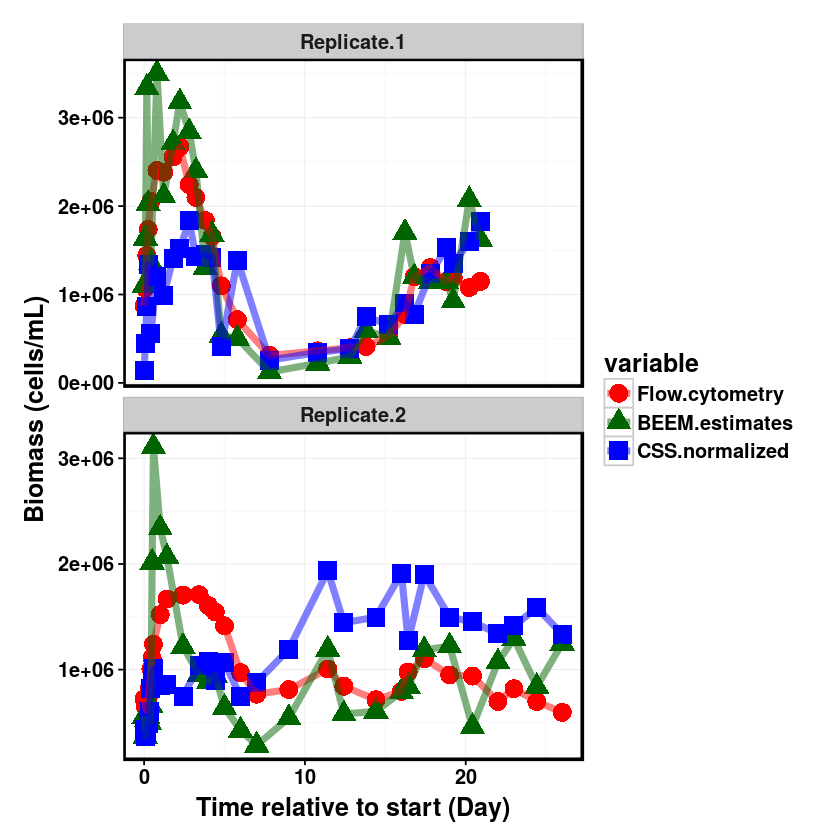

In [8]:
ggplot(melt(plot.dat.biomass, id.vars = list("time","replicate")), aes(x=time,y=value,pch=variable, col=variable)) +
    labs(x="Time relative to start (Day)",y="Biomass (cells/mL)") + 
        geom_point(size= 5) + geom_line(size=2, alpha=0.5)  + facet_wrap(~replicate,ncol=1,scale='free_y') +
            scale_color_manual(values=c('red','darkgreen','blue'))

## Scatter plot and Spearman correlations

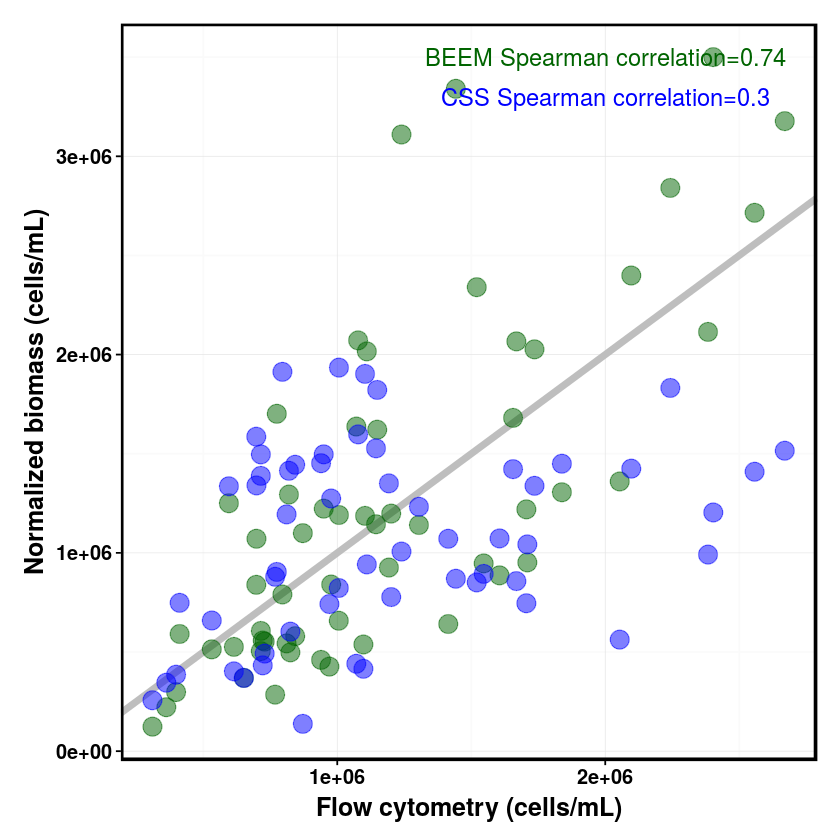

In [9]:
ggplot(plot.dat.biomass,aes(x=Flow.cytometry, y=BEEM.estimates)) +
    geom_abline(intercept = 0,slope=1, size=2, col='grey') +
    geom_point(size=5,col='darkgreen',alpha=0.5) + 
    labs(x='Flow cytometry (cells/mL)',y='Normalized biomass (cells/mL)') +
    geom_point(aes(x=Flow.cytometry,y=CSS.normalized), col='blue',size=5,alpha=0.5) + 
    annotate("text",x=2e6,y=3.5e6,size=5,label=paste0("BEEM Spearman correlation=",round(cor.test(biomass.true.sel,biomass, method='spearman')$estimate,2)),col='darkgreen') + 
    annotate("text",x=2e6,y=3.3e6,size=5,label=paste0("CSS Spearman correlation=",round(cor.test(biomass.true.sel,biomass.css.sel, method='spearman')$estimate,2)),col='blue')

## Relative error in biomass

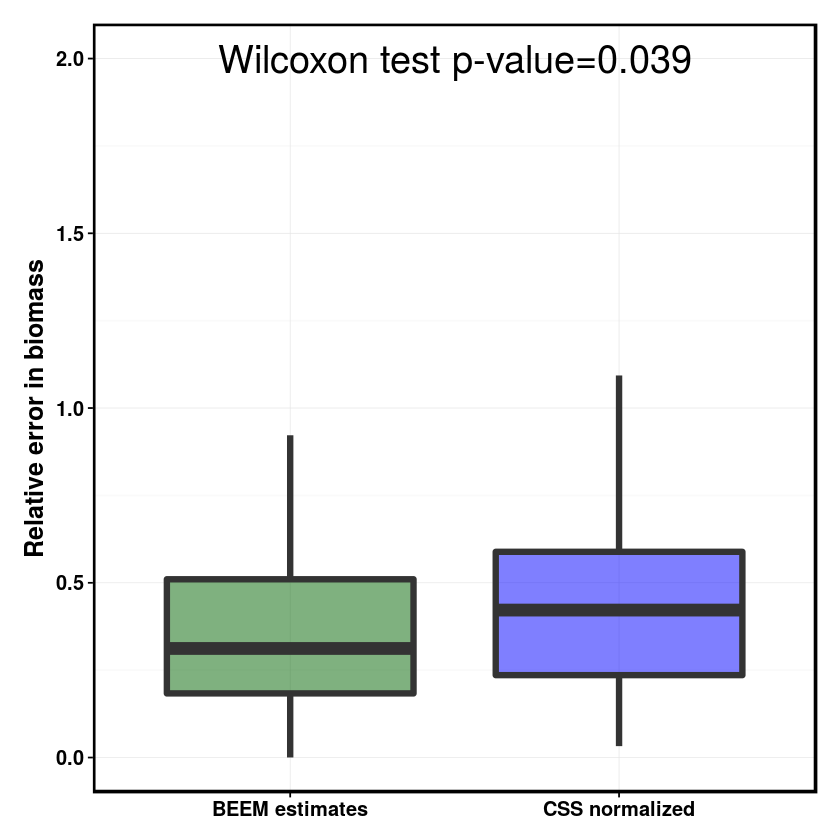

In [10]:
## function to compute relaitve error
rel_err <- function(a,b){
    a <- c(a)
    b <- c(b)
    tmp <- abs((a-b)/(a))
    ## 0/0 --> no error
    tmp[is.nan(tmp)] <- 0
    tmp 
}

beem.rel.err <- with(plot.dat.biomass, rel_err(Flow.cytometry,BEEM.estimates))
css.rel.err <- with(plot.dat.biomass, rel_err(Flow.cytometry,CSS.normalized))

c.dat <- rbind(data.frame(rel.err=beem.rel.err, method="BEEM estimates"),
               data.frame(rel.err=css.rel.err, method="CSS normalized"))

test.p <- round(wilcox.test(beem.rel.err,css.rel.err, alternative = 'less')$p.value,3)


ggplot(c.dat,aes(x=method,y=rel.err,fill=method)) +
    geom_boxplot(outlier.shape = NA, alpha=0.5, lwd=1.8) +
    labs(x=NULL,y='Relative error in biomass')+
    scale_fill_manual(values=c('darkgreen','blue'),guide='none') +
    annotate("text",x=1.5,y=2,size=8,label=paste0("Wilcoxon test p-value=",test.p))
